In [2]:
from skimage import io, transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import sys
import pandas
from conv_model import SimpleConvNet
from conv_model import SimpleConvNet2
#from conv_model import ConvNetWithPooling
from dataLoader import OrganoidDataset
%load_ext autoreload
%autoreload 2

In [3]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
  'shuffle': True, 'num_workers' : 1}

max_epochs = 100

#path = '/Users/Daley/Teaching/CS231N/CS231Nproject/CS231n_Tim_Shan_example_data/' # need to change
path = '../data/CS231n_Tim_Shan_example_data/'

well_descriptions = pandas.read_csv('processed_well_descriptions.txt', sep='\t', header=0)
#sizes = well_descriptions['mw_area shape'].tolist()
day1wells = well_descriptions[(well_descriptions['day'] == 1)]
day13wells = well_descriptions[(well_descriptions['day'] == 13)]
finalSizes = day13wells['normalized hyst2 area'].values

well_labels = []
for i in range(4800):
  i2str = str(i)
  if len(i2str) == 1:
    i2str = '000' + i2str
  if len(i2str) == 2:
    i2str = '00' + i2str
  if len(i2str) == 3:
    i2str = '0' + i2str
  well_labels.append(i2str)

initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels[0:1000], day_label_X = ['01']*1000, Y = finalSizes[0:1000])
training_generator = data.DataLoader(initial_train_set, **params)

In [6]:
use_cuda

True

In [ ]:
# model = nn.Sequential(
#     nn.Conv2d(in_channels=in_channel,out_channels=channel_1,kernel_size=5,padding=2,bias=True),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=channel_1,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),   
#     Flatten(),
#     nn.Linear(channel_2*image_size*image_size, output_channel,bias=True),
# )

In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [18]:
in_channels = 1
out_size = 1
in_channels = 1 
layer1channels = 16 
layer2channels = 16 
out_size = 1
model = nn.Sequential(
    nn.Conv2d(in_channels, layer1channels,kernel_size=3, stride=1, padding=2),
    nn.BatchNorm2d(layer1channels),
    nn.ReLU(),
    
    nn.Conv2d(layer1channels, layer2channels,
                                          kernel_size=3, stride=1, padding=2),
    nn.BatchNorm2d(layer2channels),
    nn.ReLU(),
    
    nn.Conv2d(layer2channels, layer2channels,kernel_size=3, stride=1, padding=2),
    nn.BatchNorm2d(layer2channels),
    nn.ReLU(),
    #nn.MaxPool2d(2),
    
    Flatten(),
    nn.Linear(in_features = layer2channels*193*193, out_features = out_size),
)

In [ ]:
#     self.layer1 = nn.Sequential(nn.Conv2d(in_channels, layer1channels,
#                                           kernel_size=5, stride=1, padding=2),
#                                 nn.BatchNorm2d(layer1channels),
#                                 nn.ReLU())
#     self.layer2 = nn.Sequential(nn.Conv2d(layer1channels, layer2channels,
#                                           kernel_size=5, stride=1, padding=2),
#                                 nn.BatchNorm2d(layer2channels),
#                                 nn.ReLU())
#     self.layer3 = nn.Sequential(nn.Conv2d(layer2channels, layer2channels,
#                                           kernel_size=5, stride=1, padding=2),
#                                 nn.BatchNorm2d(layer2channels),
#                                 nn.ReLU(),
#                                 nn.MaxPool2d(2),
#                                 )
#     self.fc = nn.Linear(in_features = 193*193*layer2channels, out_features = out_size)

In [19]:
model.cuda()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Flatten()
  (10): Linear(in_features=595984, out_features=1, bias=True)
)

In [20]:

#model = SimpleConvNet(in_channels = in_channels, out_size = out_size).to(device)
#model = ConvNetWithPooling(in_channels = in_channels, out_size = out_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999))
loss = nn.MSELoss()
train_error_array = np.zeros(max_epochs)




In [21]:
print_every = 100

print('using device:', device)

using device: cuda:0


In [34]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
  'shuffle': True, 'num_workers' : 1}

max_epochs = 100

#path = '/Users/Daley/Teaching/CS231N/CS231Nproject/CS231n_Tim_Shan_example_data/' # need to change
path = '../data/CS231n_Tim_Shan_example_data/'
well_descriptions = pandas.read_csv('filtered_well_descriptions.txt', header=0)
day1wells = well_descriptions['well_id']
day1wells = day1wells[well_descriptions['day'] == 1]
day1wells.shape
day13wells = well_descriptions['well_id']
day13wells = day13wells[well_descriptions['day'] == 13]
day13wells.shape
daysLabel = pandas.Series(list(set(day13wells) & set(day1wells)))


well_labels = []
for i in range(daysLabel.shape[0]):
  i2str = str(daysLabel[i])
  if len(i2str) == 1:
    i2str = '000' + i2str
  if len(i2str) == 2:
    i2str = '00' + i2str
  if len(i2str) == 3:
    i2str = '0' + i2str
  well_labels.append(i2str)

day_label_X = ['01']*len(well_labels)
n = len(well_labels)

finalSizes = well_descriptions['hyst2_area']
finalSizes = finalSizes[np.logical_and(well_descriptions['day'] == 13, np.isin(well_descriptions['well_id'], daysLabel))].values

day1_mean_and_var = pandas.read_csv('day1_mean_and_var.txt', sep = '\t', header = 0)

initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels, day_label_X = day_label_X, Y = finalSizes, intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
training_generator = data.DataLoader(initial_train_set, **params)


in_channels = 1
out_size = 1
model = SimpleConvNet(in_channels = in_channels, out_size = out_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=10**-8, weight_decay=0)
loss = nn.MSELoss()
train_error_array = np.zeros(max_epochs)

In [ ]:
# Loop over epochs
for epoch in range(max_epochs):
  # Training
  print(epoch)
  batchMSE = 0.0
  batch = 0
  print('begin training')
  for t,(local_X, local_Y) in enumerate(training_generator):
    local_X, local_Y = local_X.to(device), local_Y.to(device)
    optimizer.zero_grad()
    Y_hat = model.forward(local_X)
    train_error = loss(Y_hat, local_Y)
    train_error.backward()
    optimizer.step()
    model.eval() # set evaluation mode
    Y_hat = model.forward(local_X)
    train_error = loss(Y_hat, local_Y).item()
    batchMSE = train_error
    train_error_array[epoch] = batchMSE
    if t % print_every == 0:
        print("total_mse",totalbatchMSE)

0
begin training
total_mse 0.0
1
begin training


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total_mse 0.0
2
begin training
total_mse 0.0
3
begin training
total_mse 0.0
4
begin training
total_mse 0.0
5
begin training
total_mse 0.0
6
begin training
total_mse 0.0
7
begin training
total_mse 0.0
8
begin training
total_mse 0.0
9
begin training
total_mse 0.0
10
begin training
total_mse 0.0
11
begin training
total_mse 0.0
12
begin training
total_mse 0.0
13
begin training
total_mse 0.0
14
begin training
total_mse 0.0
15
begin training
total_mse 0.0


In [22]:
dtype = torch.float32

for epoch in range(max_epochs):
  # Training
  print(epoch)
  optimizer.zero_grad()
  totalbatchMSE = 0.0
  for t,(local_X, local_Y) in enumerate(training_generator):

    local_X, local_Y = local_X.to(device, dtype=dtype), local_Y.to(device, dtype=dtype)
    Y_hat = model.forward(local_X)
    train_error = loss(Y_hat, local_Y)
    train_error.backward()
    optimizer.step()
    model.eval() # set evaluation mode
    Y_hat = model.forward(local_X)
    train_error = loss(Y_hat, local_Y).item()
    totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/4800 # rescale train_error, since MSE = \sum sqrt(|Y - hat(Y)|^2) / batch_size
    train_error_array[epoch] = totalbatchMSE
    if t % print_every == 0:
        print("total_mse",totalbatchMSE)
        print("train_error",train_error)
    #np.savetxt(fname = "train_error_array_lr0.01_3convLayers.txt", X = train_error_array[range(epoch)])

0


RuntimeError: size mismatch, m1: [100 x 633616], m2: [595984 x 1] at /opt/conda/conda-bld/pytorch_1556653114079/work/aten/src/THC/generic/THCTensorMathBlas.cu:268

In [32]:
len(train_error_array)


200

(0, 0.4)

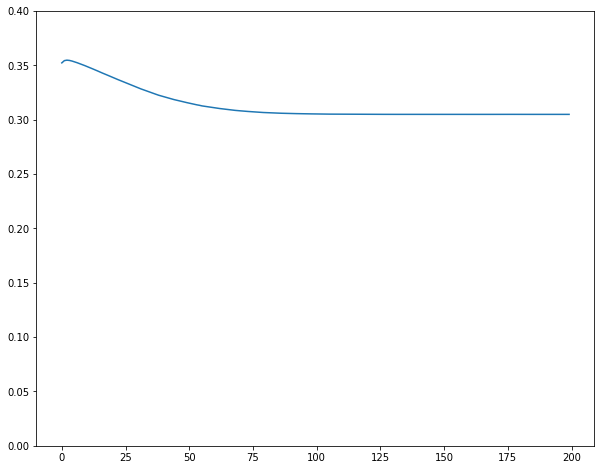

In [33]:
ax = plt.subplot(1,1,1)
ax.plot(train_error_array)
ax.set_ylim(0,0.4)

NameError: name 'set_ylim' is not defined

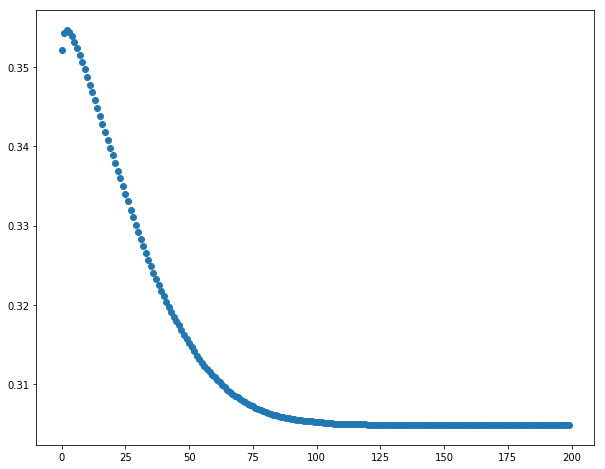

In [29]:
plt.plot(train_error_array, 'o')
set_ylim(0,0.35)
plt.xlabel('iteration')
plt.ylabel('loss')

In [34]:
dtype = torch.float32
max_epochs = 1
errors = []
for epoch in range(max_epochs):
  # Training
  print(epoch)
  optimizer.zero_grad()
  totalbatchMSE = 0.0
  for t,(local_X, local_Y) in enumerate(training_generator):

    local_X, local_Y = local_X.to(device, dtype=dtype), local_Y.to(device, dtype=dtype)
    Y_hat = model.forward(local_X)
    train_error = loss(Y_hat, local_Y)
    train_error.backward()
    optimizer.step()
    model.eval() # set evaluation mode
    Y_hat = model.forward(local_X)
    train_error = loss(Y_hat, local_Y).item()
    totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/4800 # rescale train_error, since MSE = \sum sqrt(|Y - hat(Y)|^2) / batch_size
    #train_error_array[epoch] = totalbatchMSE
    if t % print_every == 0:
        errors.append(totalbatchMSE)
        print("total_mse",totalbatchMSE)

0


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total_mse 0.007292537639538447


Text(0, 0.5, 'loss')

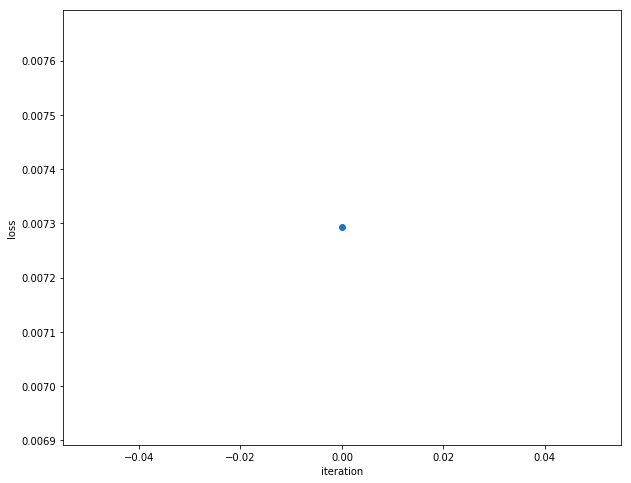

In [36]:
plt.plot(errors, 'o')
#set_ylim(0,0.35)
plt.xlabel('iteration')
plt.ylabel('loss')